## Imports

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from custom_functions import *
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Prepare datasets

In [3]:
data = pd.read_csv("drugsComTrain_raw.tsv", sep= '\t')
X_train = data.drop("rating", axis=1)
y_train = data["rating"]

In [4]:
X_train.head()

Unnamed: 0                  drugName                     condition  \
0      206461                 Valsartan  Left Ventricular Dysfunction   
1       95260                Guanfacine                          ADHD   
2       92703                    Lybrel                 Birth Control   
3      138000                Ortho Evra                 Birth Control   
4       35696  Buprenorphine / naloxone             Opiate Dependence   

                                              review               date  \
0  "It has no side effect, I take it in combinati...       May 20, 2012   
1  "My son is halfway through his fourth week of ...     April 27, 2010   
2  "I used to take another oral contraceptive, wh...  December 14, 2009   
3  "This is my first time using any form of birth...   November 3, 2015   
4  "Suboxone has completely turned my life around...  November 27, 2016   

   usefulCount  
0           27  
1          192  
2           17  
3           10  
4           37

## Data preprocessing

### drop columns

In [5]:
X_train_drop = X_train.drop(columns = ["Unnamed: 0", 'drugName', 'condition'], axis=1)
X_train_drop.head()   

review               date  \
0  "It has no side effect, I take it in combinati...       May 20, 2012   
1  "My son is halfway through his fourth week of ...     April 27, 2010   
2  "I used to take another oral contraceptive, wh...  December 14, 2009   
3  "This is my first time using any form of birth...   November 3, 2015   
4  "Suboxone has completely turned my life around...  November 27, 2016   

   usefulCount  
0           27  
1          192  
2           17  
3           10  
4           37

### Custom transformer for pipeline

In [37]:
from sklearn.base import BaseEstimator, TransformerMixin
class Drop_columns_transformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X,y=None):
        return self

    def transform(self, X, y=None):
        X_ = X.copy()
        return X_.drop(columns = ["Unnamed: 0", 'drugName', 'condition'], axis=1)

### Handle date column, extract year and month

In [7]:
X_train_drop['date'] = pd.to_datetime(X_train_drop['date'])

X_train_drop['month'] = X_train_drop['date'].apply(lambda x: x.month)
X_train_drop['year'] = X_train_drop['date'].apply(lambda x: x.year)
X_train_date = X_train_drop.drop('date', axis = 1)

In [9]:
X_train_date.head()

review  usefulCount  month  year
0  "It has no side effect, I take it in combinati...           27      5  2012
1  "My son is halfway through his fourth week of ...          192      4  2010
2  "I used to take another oral contraceptive, wh...           17     12  2009
3  "This is my first time using any form of birth...           10     11  2015
4  "Suboxone has completely turned my life around...           37     11  2016

### custom transformer for pipeline

In [40]:
from sklearn.base import BaseEstimator, TransformerMixin
class Date_transformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X,y=None):
        return self

    def transform(self, X, y=None):
        X_ = X.copy()
        X_['date'] = pd.to_datetime(X_['date'])
        X_['month'] = X_['date'].apply(lambda x: x.month)
        X_['year'] = X_['date'].apply(lambda x: x.year)
        return X_.drop('date', axis=1)

## Applying pretrained model to extract sentiment from review data

In [62]:
import joblib
sentiment_model = joblib.load("models/Random_forest_clasifier_model_for_sentimental_analysis.sav")

In [12]:
sentiment_model.classes_

array(['bad', 'good', 'mid'], dtype=object)

In [61]:
import joblib
tfidf = joblib.load("models/tfidf.sav")

In [15]:
tfidf_df = tfidf.transform(X_train_date['review'])

In [16]:
results = sentiment_model.predict_proba(tfidf_df.todense())

In [17]:
results

array([[0.08, 0.89, 0.03],
       [0.  , 0.99, 0.01],
       [0.01, 0.08, 0.91],
       ...,
       [0.99, 0.01, 0.  ],
       [0.07, 0.89, 0.04],
       [0.03, 0.92, 0.05]])

In [18]:
X_train_date['bad_sentiment'] = results[:,0]
X_train_date['good_sentiment'] = results[:,1]
X_train_date['mid_sentiment'] = results[:,2]
X_train_sentiment = X_train_date.drop("review", axis=1)

### custom transformer for pipeline

In [58]:
from sklearn.base import BaseEstimator, TransformerMixin
class Sentiment_extraction_transformer(BaseEstimator, TransformerMixin):
    def __init__(self, tfidf_vectorizer, sentiment_model):
        self.tfidf = tfidf_vectorizer
        self.sentiment_model = sentiment_model
        
    def fit(self, X,y=None):
        return self

    def transform(self, X, y=None):
        X_ = X.copy()
        tfidf_df = self.tfidf.transform(X_['review'])
        results = self.sentiment_model.predict_proba(tfidf_df.todense())
        X_['bad_sentiment'] = results[:,0]
        X_['good_sentiment'] = results[:,1]
        X_['mid_sentiment'] = results[:,2]
        X_ = X_.drop("review", axis=1)
        return X_

In [55]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler_min_max = MinMaxScaler()
scaled_data_min_max = scaler_min_max.fit_transform(X_train_sentiment)
scaler_std = StandardScaler()
scaled_std = scaler_std.fit_transform(X_train_sentiment)

## Make pipeline

In [67]:
from sklearn.pipeline import Pipeline

steps = [
    ("column_drop", Drop_columns_transformer()),
    ("date_transformer", Date_transformer()),
    ("Sentiment_extraction", Sentiment_extraction_transformer(tfidf, sentiment_model)),
    ("Scaler", MinMaxScaler())
]
pre_procesing_pipeline = Pipeline(steps=steps)

In [68]:
pre_procesing_pipeline.fit(X_train)

C:\Users\Lenowo\anaconda3\envs\DataScience\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


Pipeline(steps=[('column_drop', Drop_columns_transformer()),
                ('date_transformer', Date_transformer()),
                ('Sentiment_extraction',
                 Sentiment_extraction_transformer(sentiment_model=RandomForestClassifier(),
                                                  tfidf_vectorizer=None)),
                ('Scaler', MinMaxScaler())])

In [72]:
X_train_processed = pre_procesing_pipeline.transform(X_train)

In [70]:
data_test = pd.read_csv("drugsComTest_raw.tsv", sep= '\t')
X_test = data_test.drop("rating", axis=1)
y_test = data_test["rating"]

In [73]:
X_test_processed = pre_procesing_pipeline.transform(X_test)

## Model selection
- training on train set 
- testing on test set

In [76]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

### Logistic regression

In [89]:
model_1 = LogisticRegression(solver = "liblinear")
model_1.fit(X_train_processed, y_train)
y_pred = model_1.predict(X_test_processed)
f1 = f1_score(y_test, y_pred, average = 'macro')
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average = 'macro')
recall = recall_score(y_test, y_pred, average = 'macro')
metrics_names = ["Accuracy-score", 'F1-scorre', "Precision-score", 'Recall-score']
metrics_results = [accuracy, f1, precision, recall]
joblib.dump(model_1, "models/Logistic_regression_no_tunned.sav")

C:\Users\Lenowo\anaconda3\envs\DataScience\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


['Logistic_regression_no_tunned.sav']

[Text(0.5, 1.0, 'Logistic Regression - no tunning test set')]

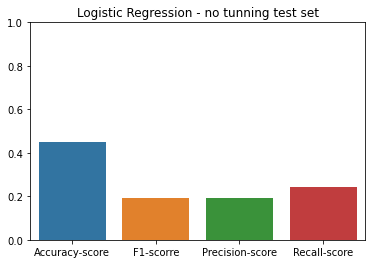

In [90]:
g = sns.barplot(x = metrics_names,  y = metrics_results)
g.set(ylim = (0, 1))
g.set(title = "Logistic Regression - no tunning test set")

### Linear regression

In [96]:
model_2 = LinearRegression()
model_2.fit(X_train_processed, y_train)
y_pred = np.rint(model_2.predict(X_test_processed))
f1 = f1_score(y_test, y_pred, average = 'macro')
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average = 'macro')
recall = recall_score(y_test, y_pred, average = 'macro')
metrics_names = ["Accuracy-score", 'F1-scorre', "Precision-score", 'Recall-score']
metrics_results = [accuracy, f1, precision, recall]
joblib.dump(model_2, "models/Linear_regression_no_tunned.sav")

['Linear_regression_no_tunned.sav']

[Text(0.5, 1.0, 'Linear Regression - no tunning test set')]

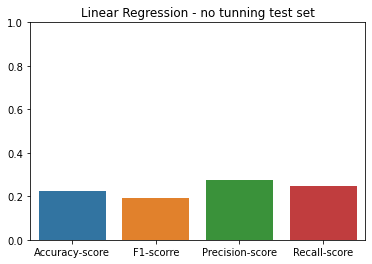

In [92]:
g2 = sns.barplot(x = metrics_names,  y = metrics_results)
g2.set(ylim = (0, 1))
g2.set(title = "Linear Regression - no tunning test set")

### MultinomialNB

In [100]:
model_3 = MultinomialNB()
model_3.fit(X_train_processed, y_train)
y_pred = model_3.predict(X_test_processed)
f1 = f1_score(y_test, y_pred, average = 'macro')
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average = 'macro')
recall = recall_score(y_test, y_pred, average = 'macro')
metrics_names = ["Accuracy-score", 'F1-scorre', "Precision-score", 'Recall-score']
metrics_results = [accuracy, f1, precision, recall]
joblib.dump(model_3, "models/MultinominalNB.sav")

C:\Users\Lenowo\anaconda3\envs\DataScience\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


['MultinominalNB.sav']

[Text(0.5, 1.0, 'MultinominalNB - no tunning test set')]

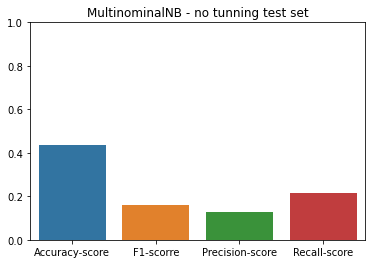

In [101]:
g3 = sns.barplot(x = metrics_names,  y = metrics_results)
g3.set(ylim = (0, 1))
g3.set(title = "MultinominalNB - no tunning test set")

### XGBClassifier

In [110]:
y_train_for_xgboost = y_train.astype(int)-1
y_test_for_xgboost = y_test.astype(int)-1
model_4 = XGBClassifier(use_label_encoder=False, eval_metric = 'mlogloss')
model_4.fit(X_train_processed, y_train_for_xgboost)
y_pred = model_4.predict(X_test_processed)
f1 = f1_score(y_test_for_xgboost, y_pred, average = 'macro')
accuracy = accuracy_score(y_test_for_xgboost, y_pred)
precision = precision_score(y_test_for_xgboost, y_pred, average = 'macro')
recall = recall_score(y_test_for_xgboost, y_pred, average = 'macro')
metrics_names = ["Accuracy-score", 'F1-scorre', "Precision-score", 'Recall-score']
metrics_results = [accuracy, f1, precision, recall]
joblib.dump(model_4, "XGBClassifier.sav")

['XGBClassifier.sav']

[Text(0.5, 1.0, 'XGBClassifier - no tunning test set')]

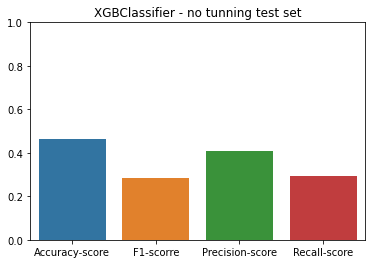

In [111]:
g4 = sns.barplot(x = metrics_names,  y = metrics_results)
g4.set(ylim = (0, 1))
g4.set(title = "XGBClassifier - no tunning test set")

### RandomForestClassifier

In [112]:
model_5 = RandomForestClassifier()
model_5.fit(X_train_processed, y_train)
y_pred = model_5.predict(X_test_processed)
f1 = f1_score(y_test, y_pred, average = 'macro')
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average = 'macro')
recall = recall_score(y_test, y_pred, average = 'macro')
metrics_names = ["Accuracy-score", 'F1-scorre', "Precision-score", 'Recall-score']
metrics_results = [accuracy, f1, precision, recall]
joblib.dump(model_5, "RandomForestClassifier.sav")

['RandomForestClassifier.sav']

[Text(0.5, 1.0, 'RandomForestClassifier - no tunning test set')]

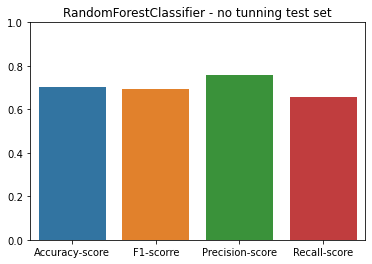

In [113]:
g5 = sns.barplot(x = metrics_names,  y = metrics_results)
g5.set(ylim = (0, 1))
g5.set(title = "RandomForestClassifier - no tunning test set")

## RandomForestClassifier tunning

In [116]:
from pprint import pprint
pprint(model_5.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [120]:

from sklearn.model_selection import GridSearchCV
param_grid = {
    'bootstrap': [True],
    'criterion': ['gini', 'entropy'],
    'max_depth': [70,80, 90],
    'max_features': [2, 3, 4],
    'min_samples_leaf': [2, 3, 4],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [50,100, 200]
}# Create a based model
rf = RandomForestClassifier()# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

In [121]:
grid_search.fit(X_train_processed, y_train)

Fitting 3 folds for each of 486 candidates, totalling 1458 fits
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:  4.7min
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed: 30.3min
[Parallel(n_jobs=5)]: Done 355 tasks      | elapsed: 77.7min
[Parallel(n_jobs=5)]: Done 638 tasks      | elapsed: 142.7min
[Parallel(n_jobs=5)]: Done 1003 tasks      | elapsed: 242.9min
[Parallel(n_jobs=5)]: Done 1448 tasks      | elapsed: 368.0min
[Parallel(n_jobs=5)]: Done 1458 out of 1458 | elapsed: 371.9min finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=5,
             param_grid={'bootstrap': [True], 'criterion': ['gini', 'entropy'],
                         'max_depth': [70, 80, 90], 'max_features': [2, 3, 4],
                         'min_samples_leaf': [2, 3, 4],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [50, 100, 200]},
             verbose=2)

In [123]:
grid_search.best_params_

{'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': 70,
 'max_features': 4,
 'min_samples_leaf': 2,
 'min_samples_split': 8,
 'n_estimators': 200}

In [ ]:
### Check best params

In [125]:
model_6 = RandomForestClassifier(
    bootstrap = True,
    criterion = 'entropy',
    max_depth = 70,
    max_features = 4,
    min_samples_leaf = 2,
    min_samples_split = 8,
    n_estimators = 200
)
model_6.fit(X_train_processed, y_train)
y_pred = model_6.predict(X_test_processed)
f1 = f1_score(y_test, y_pred, average = 'macro')
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average = 'macro')
recall = recall_score(y_test, y_pred, average = 'macro')
metrics_names = ["Accuracy-score", 'F1-scorre', "Precision-score", 'Recall-score']
metrics_results = [accuracy, f1, precision, recall]
joblib.dump(model_6, "RandomForestClassifier_tuned.sav")

['RandomForestClassifier_tuned.sav']

### overfitting

[Text(0.5, 1.0, 'RandomForestClassifier - tunned test set')]

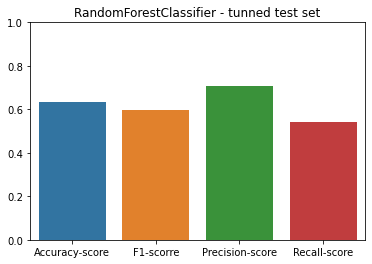

In [127]:
g6 = sns.barplot(x = metrics_names,  y = metrics_results)
g6.set(ylim = (0, 1))
g6.set(title = "RandomForestClassifier - tunned test set")